# Unsupervised ML: Clustering songs for _Moosic_

The (fictitious) music company _Moosic_ provides curated playlists for Spotify users. In this notebook, we examine whether automatic analysis of music features as provided by Spotify itself can help in clustering songs for either automatically generating playlists or for helping the playlist curators in their work.

## Library setup

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances, pairwise
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.core.display import HTML
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.colors as mcolors

In [2]:
from sklearn import set_config
set_config(transform_output="pandas")

## Import data
This also drops duplicates and fixes whitespace problems in column names and in the `id` column.

In [3]:
spotify_df = (
  # pd.read_csv('https://drive.google.com/uc?export=download&id=1oYQSNxfvw6kFr6-N9rKLRAnLXlp0osEt', index_col=0)
  pd.read_csv('../data/6.3.3_spotify_5000_songs.csv', index_col=0)
  .pipe(lambda x: [print(f'Raw count: {len(x)}'), x][-1])
  .drop_duplicates()
  .pipe(lambda x: [print(f'Without duplicates: {len(x)}'), x][-1])
  .rename(columns=lambda x: x.strip())
  .assign(id=lambda x: x.id.str.strip())
)

Raw count: 5235
Without duplicates: 5171


There is a single record with all-zero measures - probably faulty, drop it:

In [4]:
clean_df = spotify_df[lambda x: x.time_signature != 0]

## Scaling data to standard amplitude

Columns that are not used as measures (meta data) and columns that are discrete and need special (or no) scaling:

In [5]:
meta = ['name', 'artist', 'id', 'html', 'duration_ms', 'type', 'loudness']
categoricals = ['key', 'mode', 'time_signature']

In [6]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler

Rescale measures based on the 10% to 90% quantiles (in order to limit the effect of outliers which we decided not to drop). No centering because we want to later draw spider diagrams and they suffer from negative values.

In [7]:
scaler = RobustScaler(with_centering=False, quantile_range=(10,90))
scaled_df = (
  scaler.fit_transform(
    clean_df.drop(columns=[*meta, *categoricals])
  )
  .join(spotify_df[categoricals])
)
scaled_df

danceability    energy  speechiness  acousticness  instrumentalness  \
0         1.136246  0.320148     0.503931      0.739100          0.000065   
1         1.281299  0.493201     0.247320      0.231102          0.000002   
2         1.469522  0.902349     2.480343      0.482439          0.000070   
3         1.217406  0.062052     0.336669      0.936122          0.000045   
4         1.124158  0.147095     0.271623      0.975527          0.000380   
...            ...       ...          ...           ...               ...   
5230      0.348817  0.085785     0.338099      0.976592          0.792683   
5231      0.324642  0.124845     0.315940      0.910563          0.472284   
5232      0.102918  0.001150     0.310222      1.012801          1.074279   
5233      0.229667  0.025711     0.299500      0.940382          0.559867   
5234      0.611293  0.060198     0.230879      0.833884          0.536585   

      liveness   valence     tempo  key  mode  time_signature  
0     3.326510  0.400419  1.425964   11     0               4  
1     0.365063  0.906831  1.615397    2     1               4  
2     0.423064  1.184245  1.210498    2     1               4  
3     1.316957  0.685684  1.379791    4     1               4  
4     0.354828  0.526040  1.562454    6     1               4  
...        ...       ...       ...  ...   ...             ...  
5230  0.283862  0.085711  1.135670    3     1               4  
5231  0.236779  0.046454  1.074020    6     1               4  
5232  0.263391  0.045014  0.924662    9     1               3  
5233  0.378710  0.077336  0.866991    4     1               4  
5234  0.968953  0.331065  0.828376    5     1               3  

[5170 rows x 11 columns]

### Histograms of the rescaled measures

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


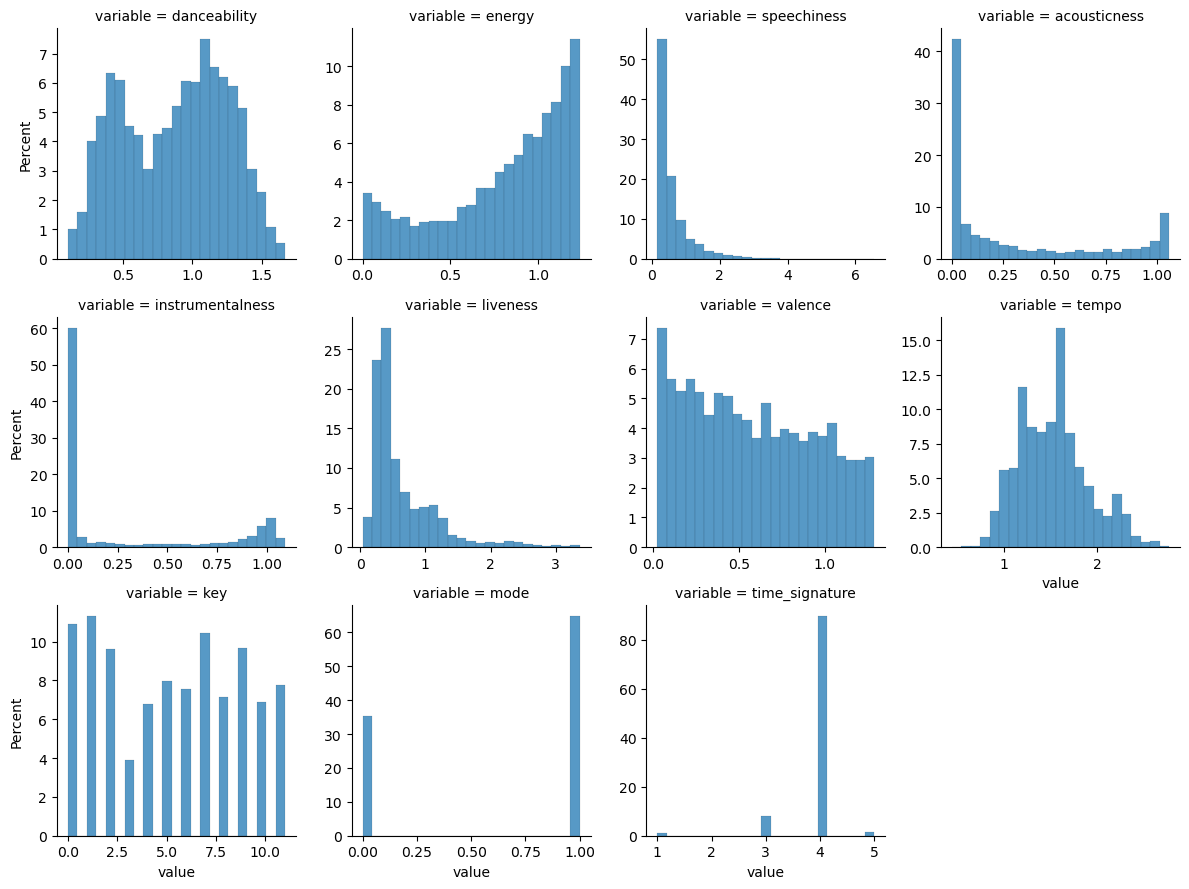

In [8]:
sns.displot(
    data = pd.melt(scaled_df, ignore_index=False),
    x='value',
    col='variable',
    stat='percent',
    bins=23,
    facet_kws={ 'sharex': False, 'sharey':False },
    common_bins=False,
    common_norm=False,
    col_wrap=4,
    height=3);

## Principal Component Analysis

We drop:

- _time signature_ because we donot deem it essential for the mood (even though Waltz dancers will disagree)
- _key_ because key is important for ordering songs harmonically but not so much for clustering songs by mood because a song sounds comparable in C major as D major (even though some people will disagree)
- _liveness_ because we only know that values above 0.8 give high probability for the presence of a live audience, of which there are only 0.8% in the data-set and values below the threshold are unclear to interpret and seemed to create implausible clusters (more investigation needed!)

In [9]:
(clean_df.liveness > 0.8).value_counts(normalize=True)

liveness
False    0.991683
True     0.008317
Name: proportion, dtype: float64

In [10]:
pca_df = scaled_df.drop(columns=['key', 'time_signature', 'liveness'])
pca_df

danceability    energy  speechiness  acousticness  instrumentalness  \
0         1.136246  0.320148     0.503931      0.739100          0.000065   
1         1.281299  0.493201     0.247320      0.231102          0.000002   
2         1.469522  0.902349     2.480343      0.482439          0.000070   
3         1.217406  0.062052     0.336669      0.936122          0.000045   
4         1.124158  0.147095     0.271623      0.975527          0.000380   
...            ...       ...          ...           ...               ...   
5230      0.348817  0.085785     0.338099      0.976592          0.792683   
5231      0.324642  0.124845     0.315940      0.910563          0.472284   
5232      0.102918  0.001150     0.310222      1.012801          1.074279   
5233      0.229667  0.025711     0.299500      0.940382          0.559867   
5234      0.611293  0.060198     0.230879      0.833884          0.536585   

       valence     tempo  mode  
0     0.400419  1.425964     0  
1     0.906831  1.615397     1  
2     1.184245  1.210498     1  
3     0.685684  1.379791     1  
4     0.526040  1.562454     1  
...        ...       ...   ...  
5230  0.085711  1.135670     1  
5231  0.046454  1.074020     1  
5232  0.045014  0.924662     1  
5233  0.077336  0.866991     1  
5234  0.331065  0.828376     1  

[5170 rows x 8 columns]

We conduct a 95% PCA and reduce the dimensionality from 9 to 6.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


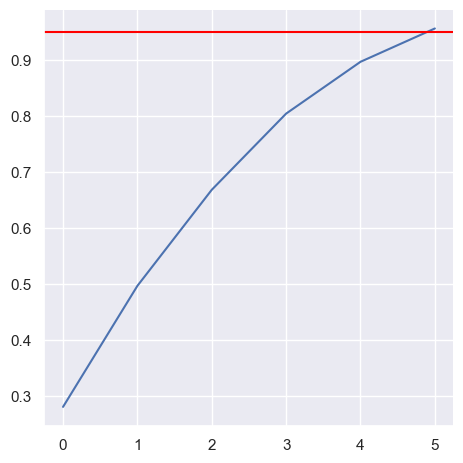

In [11]:
pca = PCA(n_components=0.95, random_state=19201)
pca.fit(pca_df)
sns.set_theme()
sns.relplot(
    x=np.arange(len(pca.explained_variance_ratio_)),
    y=np.cumsum(pca.explained_variance_ratio_),
    kind='line'
);
plt.axhline(y=0.95, color='red');

### Principal directions

In [12]:
pca_direction_df = pd.DataFrame(
    np.c_[pca.components_, pca.explained_variance_ratio_],
    columns=list(pca_df.columns) + ['explained_variance_ratio'],
    index=pd.Index(np.arange(pca.n_components_), name='pca')
)
pca_direction_df

danceability    energy  speechiness  acousticness  instrumentalness  \
pca                                                                        
0        0.350382  0.398831     0.463179     -0.427383         -0.423705   
1       -0.451230  0.241294     0.581716     -0.225153          0.417322   
2        0.066856 -0.102265     0.043561      0.091748          0.053458   
3        0.187583 -0.421071     0.652999      0.468180         -0.104036   
4       -0.030572 -0.221763     0.123976      0.282631          0.003426   
5        0.314573  0.054818     0.031111     -0.027847          0.781384   

      valence     tempo      mode  explained_variance_ratio  
pca                                                          
0    0.334146  0.151117 -0.083424                  0.280750  
1   -0.413031  0.063472 -0.017317                  0.215856  
2   -0.036984 -0.069971 -0.982668                  0.171269  
3    0.052003 -0.327675  0.144957                  0.135854  
4    0.070119  0.921671 -0.015198                  0.092381  
5    0.532984 -0.014848  0.037982                  0.059436

#### As spider plot: absolute value of coefficients

In [13]:
def close_list(x):
  return list(x) + [x[0]]
pca_direction_fig = go.Figure()
pca_direction_fig.add_traces([
    go.Scatterpolar(
      r=close_list(pca_direction_df.iloc[row, 0:-1].abs()),
      theta=close_list(pca_direction_df.columns[0:-1]),
      name=f'pca{row}',
      fill='toself'
    )
  for row in np.arange(pca.n_components_)
])

/tmp/ipykernel_18033/1390423494.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## k-means: Clustering

In [14]:
kmeans_df = pca.transform(pca_df)
kmeans_df

pca0      pca1      pca2      pca3      pca4      pca5
0    -0.228317 -0.426391  0.737458  0.357652  0.107490 -0.303430
1     0.104223 -0.699468 -0.342983  0.015817  0.084196  0.062878
2     1.291706  0.416471 -0.233833  1.601773 -0.018148  0.360912
3    -0.459566 -0.805029 -0.209920  0.639496  0.159442 -0.112044
4    -0.531173 -0.711471 -0.230928  0.493977  0.303669 -0.227374
...        ...       ...       ...       ...       ...       ...
5230 -1.344287  0.147450 -0.184998  0.452780 -0.072005 -0.081857
5231 -1.205902  0.048352 -0.208994  0.437907 -0.162008 -0.356534
5232 -1.657387  0.334548 -0.159351  0.478769 -0.235310  0.035753
5233 -1.357152  0.061664 -0.185160  0.525392 -0.319078 -0.305217
5234 -1.107139 -0.235121 -0.183860  0.516058 -0.394879 -0.064831

[5170 rows x 6 columns]

In [15]:
inertia = {}
silhouette_scores = {}
kmeans = {}

In [16]:
for k in range(2, 20):
  km = KMeans(n_clusters=k, n_init='auto', random_state=19201)
  km.fit(kmeans_df);
  inertia[k] = km.inertia_
  silhouette_scores[k] = silhouette_score(kmeans_df, km.labels_)
  kmeans[k] = km

### Identifying optimal number of clusters from inertia and silhouette score

In [17]:
k_df = MinMaxScaler().set_output(transform='pandas').fit_transform(
  pd.DataFrame(
    list(sorted(inertia.items())),
    columns=['k','inertia'])
  .set_index('k')
  .join(
    pd.DataFrame(
        list(sorted(silhouette_scores.items())),
        columns=['k','silhouette'])
    .set_index('k')
    )
)
k_df

inertia  silhouette
k                       
2   1.000000    0.000000
3   0.779585    0.027120
4   0.536514    0.640463
5   0.364393    0.977287
6   0.300942    1.000000
7   0.278825    0.909479
8   0.215016    0.700632
9   0.189157    0.660201
10  0.156456    0.296359
11  0.141866    0.315651
12  0.106180    0.506783
13  0.071363    0.662445
14  0.064339    0.405239
15  0.036306    0.464667
16  0.021152    0.449272
17  0.015633    0.430690
18  0.010183    0.394224
19  0.000000    0.386209

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



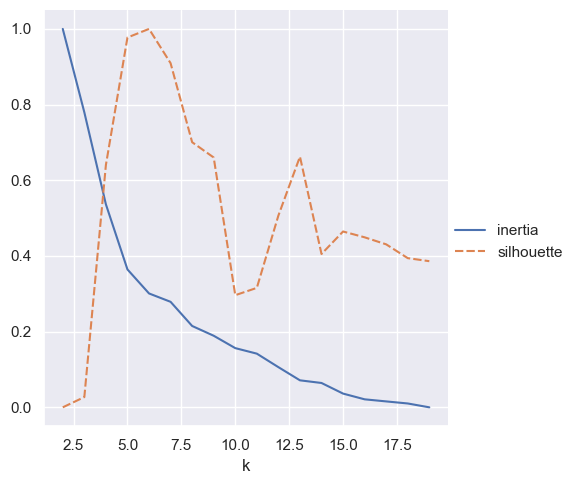

In [18]:
sns.relplot(k_df, kind='line');

Label the songs by cluster and calculate distance to cluster center:

In [19]:
k=6
labeled_df = (
  kmeans_df
  .assign(
    label=kmeans[k].labels_,
    distance=[
    kmeans[k].transform(kmeans_df.iloc[[i]]).iloc[0,kmeans[k].labels_[i]]
    for i in range(len(kmeans_df))
  ])
  .reset_index()
  .set_index('index')
  .sort_values(['index','distance'])
  .groupby(lambda x:x)
  .first()
  .sort_values(['label','distance'])
)

Write song labels to disk:

In [32]:
labeled_df[['label', 'distance']].to_csv('../data/6.3.3_spotify_5000_songs_labels.csv')

### Characterize clusters by measure statistics

In [20]:
label_characteristics_df = (
    pca_df
    .rename(columns={
        'danceability': 'dance',
        'instrumentalness': 'instr.',
        'acousticness': 'acoust.'
    })
    .join(labeled_df.label)
    .groupby('label')
    .agg(['mean','std'])
)
label_characteristics_df

dance              energy           speechiness             acoust.  \
           mean       std      mean       std        mean       std      mean   
label                                                                           
0      0.473385  0.198447  1.129886  0.110325    0.759668  0.341614  0.008496   
1      1.076768  0.246304  0.828883  0.239450    0.394741  0.218812  0.275566   
2      1.145814  0.226660  0.847218  0.239416    0.455710  0.252351  0.242100   
3      0.573217  0.259980  0.176258  0.144156    0.318651  0.099929  0.984383   
4      1.156675  0.310901  0.914839  0.204350    1.992283  0.591221  0.189330   
5      0.535665  0.240556  1.115507  0.131083    0.728106  0.338872  0.015758   

                   instr.             valence               tempo            \
            std      mean       std      mean       std      mean       std   
label                                                                         
0      0.040283  0.624756  0.390198  0.288169  0.188369  1.566346  0.367325   
1      0.287627  0.044443  0.151317  0.801767  0.298848  1.566622  0.330113   
2      0.281957  0.047762  0.160252  0.765455  0.294331  1.544053  0.312860   
3      0.113537  0.718376  0.414738  0.234524  0.196231  1.357253  0.420529   
4      0.220754  0.031202  0.140197  0.743668  0.308351  1.583513  0.459645   
5      0.066315  0.618084  0.398751  0.293792  0.182416  1.598724  0.351349   

           mode            
           mean       std  
label                      
0      1.000000  0.000000  
1      1.000000  0.000000  
2      0.000000  0.000000  
3      0.662546  0.473134  
4      0.602151  0.490113  
5      0.000000  0.000000

In [21]:
cluster_sizes_df = (
  labeled_df['label'].value_counts().sort_index().rename('count').to_frame()
)
cluster_sizes_df

count
label       
0        822
1       1765
2        980
3        809
4        372
5        422

#### Cluster spider diagrams

In [22]:
# State the label for each arm of the chart
categories = [ tuple[0] for tuple in label_characteristics_df.columns if tuple[1] == 'mean' ]
categories.append(categories[0])

In [23]:
colormap = px.colors.qualitative.Plotly

In [24]:
# Create an empty list to store the objects
trace_objects = []

# Iterate over the unique cluster numbers and add an object for each cluster to the list
label_order = [1, 3, 0, 2, 4, 5]

for i, label in enumerate(label_order):
  color = colormap[i % len(colormap)]
  light_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
  light_color[1] *= 0.4
  #light_color[2] *= 0.85
  light_color = mcolors.to_hex(mcolors.hsv_to_rgb(light_color))

  label_traces = []
  label_means = go.Scatterpolar(
    r=[label_characteristics_df.loc[label, (category, 'mean')] for category in categories],
    theta=categories,
    #fill='none',
    line_color=color,
    name=f'Cluster {label} mean',
    subplot=f'polar{i+1}',
  )
  label_traces.append(label_means)
  for plus_minus in [+1, -1]:
      label_mean_plus_std = go.Scatterpolar(
        r=[
            max(0, label_characteristics_df.loc[label, (category, 'mean')]
            + plus_minus * label_characteristics_df.loc[label, (category, 'std')])
            for category in categories
        ],
        theta=categories,
        fill='tonext' if plus_minus < 1 else 'none',
        line_color=light_color,
        name=f'Cluster {label} mean {"+" if plus_minus > 0 else "-"} std',
        subplot=f'polar{i+1}'
      )
      label_traces.append(label_mean_plus_std)

  trace_objects.append(label_traces)

# Add the objects to the figure
columns = 3
rows = math.ceil(k / columns)
fig = make_subplots(
  rows=rows,
  cols=columns,
  #horizontal_spacing = 0.18,
  subplot_titles=[ f'Cluster {label} ({cluster_sizes_df.loc[label, "count"]})' for label in label_order ],
  specs=[ [ {'type': 'polar' } for column in np.arange(columns) ] for row in np.arange(rows) ] )

for annotation in fig.layout.annotations:
  annotation.update(y=annotation.y+.035)

for i, traces in enumerate(trace_objects):
  for trace in traces:
    fig.add_trace(
      trace,
      row=(i // columns) + 1,
      col=(i % columns) + 1
    )

# Add extras to the plot such as title
# You'll always need `polar=dict(radialaxis=dict(visible=True,range=[0, 1]))` when creating a radar plot
plot_specs = dict(
  radialaxis=dict(
    visible=True,
    range=[0, 2.2],
  )
)

fig.update_layout(
  title_text = 'Radar chart of mean characteristics by cluster',
  height = 800*.8,
  width = 1200*.8,
  margin = dict(l=50, r=50),
  **{ f'polar{i+1}': plot_specs for i in np.arange(k) },
  showlegend=False
)

# Show the initialised plot and the layers
fig.show()

## Results

### Helpers for embedding Spotify songs

In [25]:
def make_spotify_link(url):
    return f'<a href="{url}">Play</a>'

def embed_spotify(trackid):
  return f'<iframe style="border-radius:12px" src="https://open.spotify.com/embed/track/{trackid.strip()}?utm_source=generator" width="100%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>'

HTML(embed_spotify('1bn6wzEDn5PqLfin3O3eWG'))

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning:

Consider using IPython.display.IFrame instead



### List of top 5 songs per cluster

In [26]:
(
  labeled_df
  [['label', 'distance']]
  .groupby('label')
  .head(5)
  #.sample(5)
  .join(spotify_df[[
    'id',
    'artist',
    'name',
    'html']])
  .pipe(lambda x: x.style.format({
    'id': embed_spotify,
    'html': make_spotify_link
  }))
)

Inspection of the generated clustering leads us to the following mapping of clusters to song-type:

| cluster | description               |
|---------|---------------------------|
| 0       | Metal in major            |
| 1       | Pop/Rock in major         |
| 2       | Pop/Rock in minor         |
| 3       | Instrumental              |
| 4       | Hip-Hop/Rap/Spoken Lyrics |
| 5       | Metal in minor            |

## Conclusions

- PCA is effective to identify most relevant directions
- k-means is effective to identify clusters
- songs can be clustered effectively using PCA and k-means on the Spotify song measures
- the resulting clusters are not flawless and need review
- the generated clusters still can be refined as for example clusters 3 and 4 donot yet reflect major/minor mode which may be a useful distinction
- the derived clusters could further be structured using another level of PCA/k-means to generate sub-clusters
- PCA and k-means are quite sensitive to scaling, so clustering could and probably still needs to be improved by reweighting the different measures

*This was a great project! Thanks to my team partners Hanne Prüfert and Sebastian Foth!*



## Appendix


### Characterizing clusters in PCA space


/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1

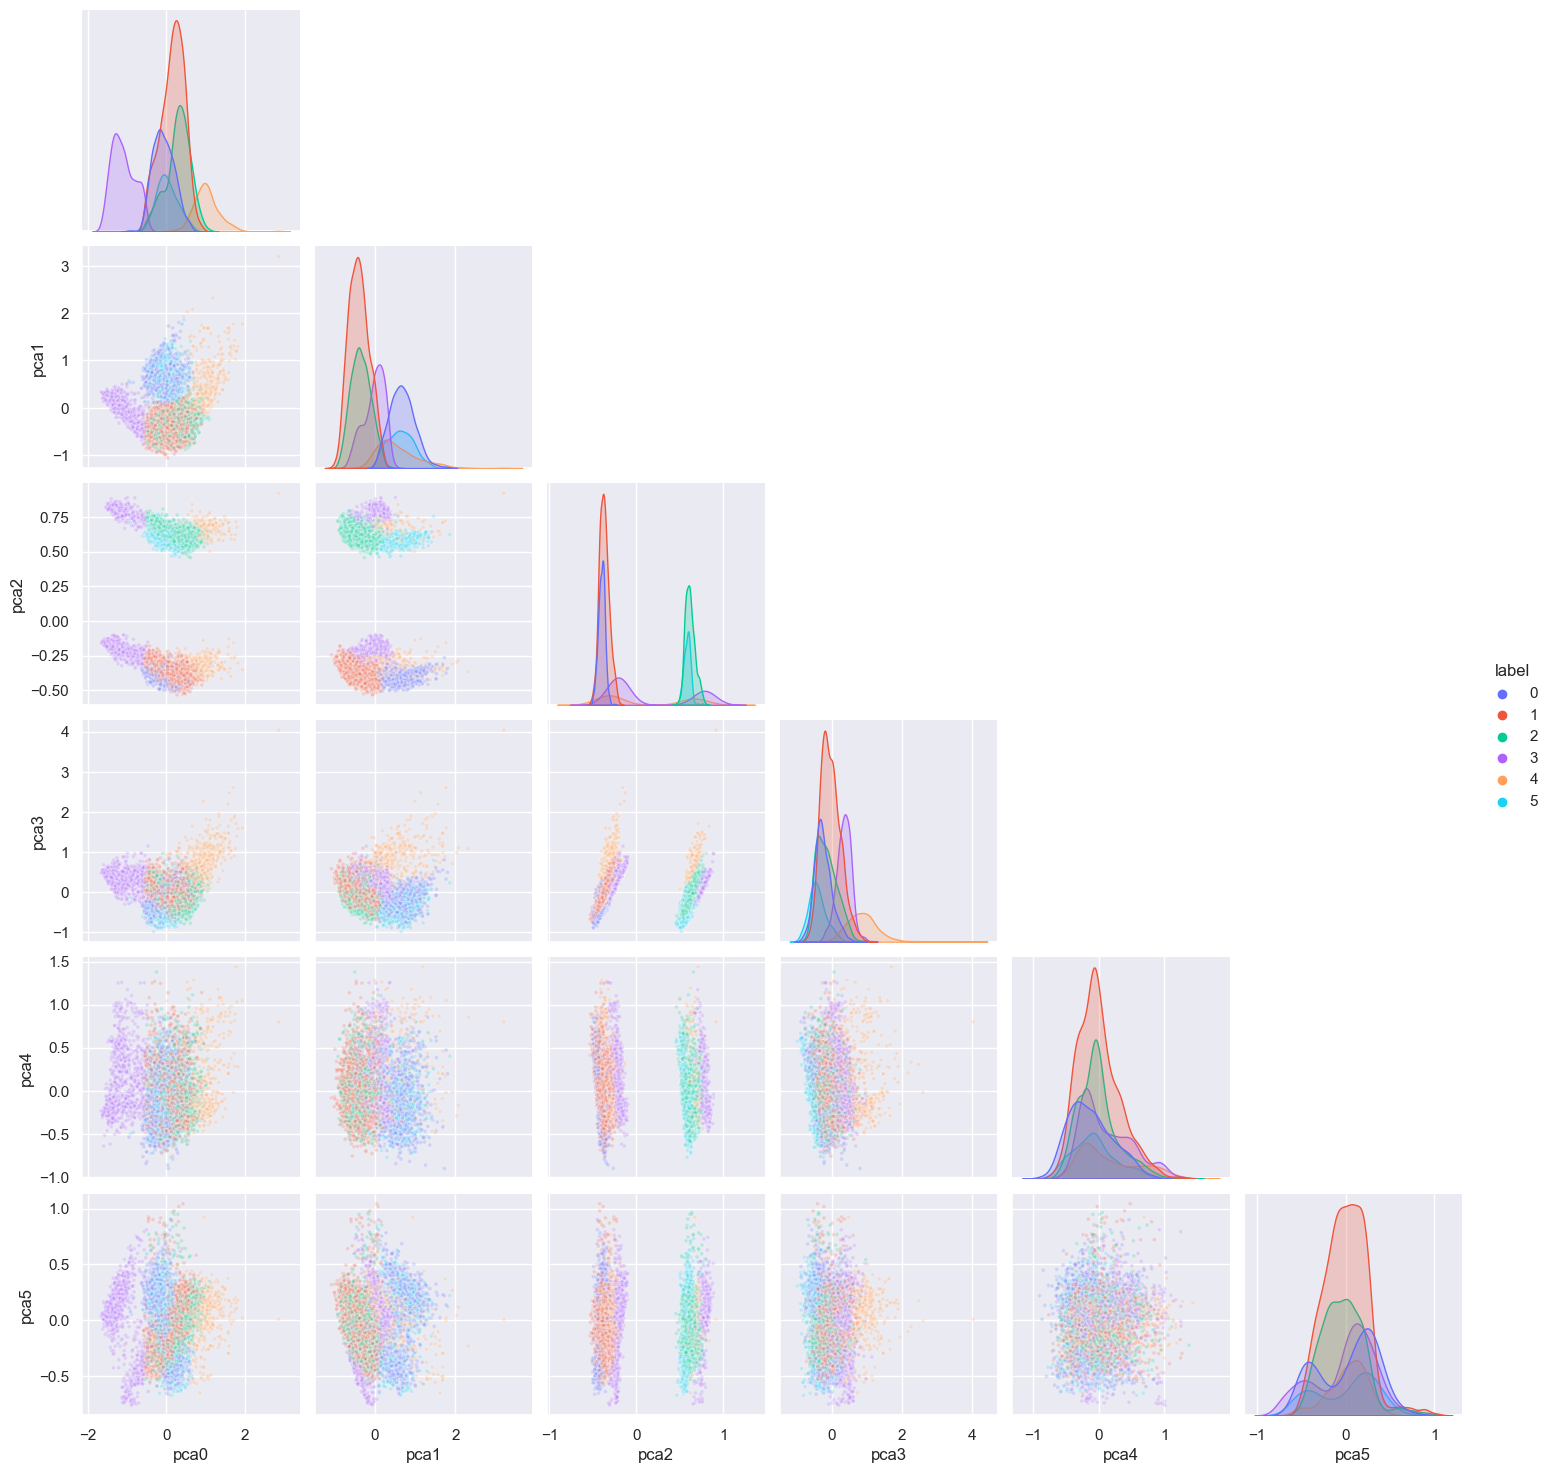

In [27]:
sns.pairplot(
    data=kmeans_df.join(labeled_df.label),
    palette=colormap[0:k],
    plot_kws=dict(marker=".", linewidth=1, alpha=0.2),
    corner=True,
    hue='label',);

### Characterizing clusters in original feature space

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/til/local/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1

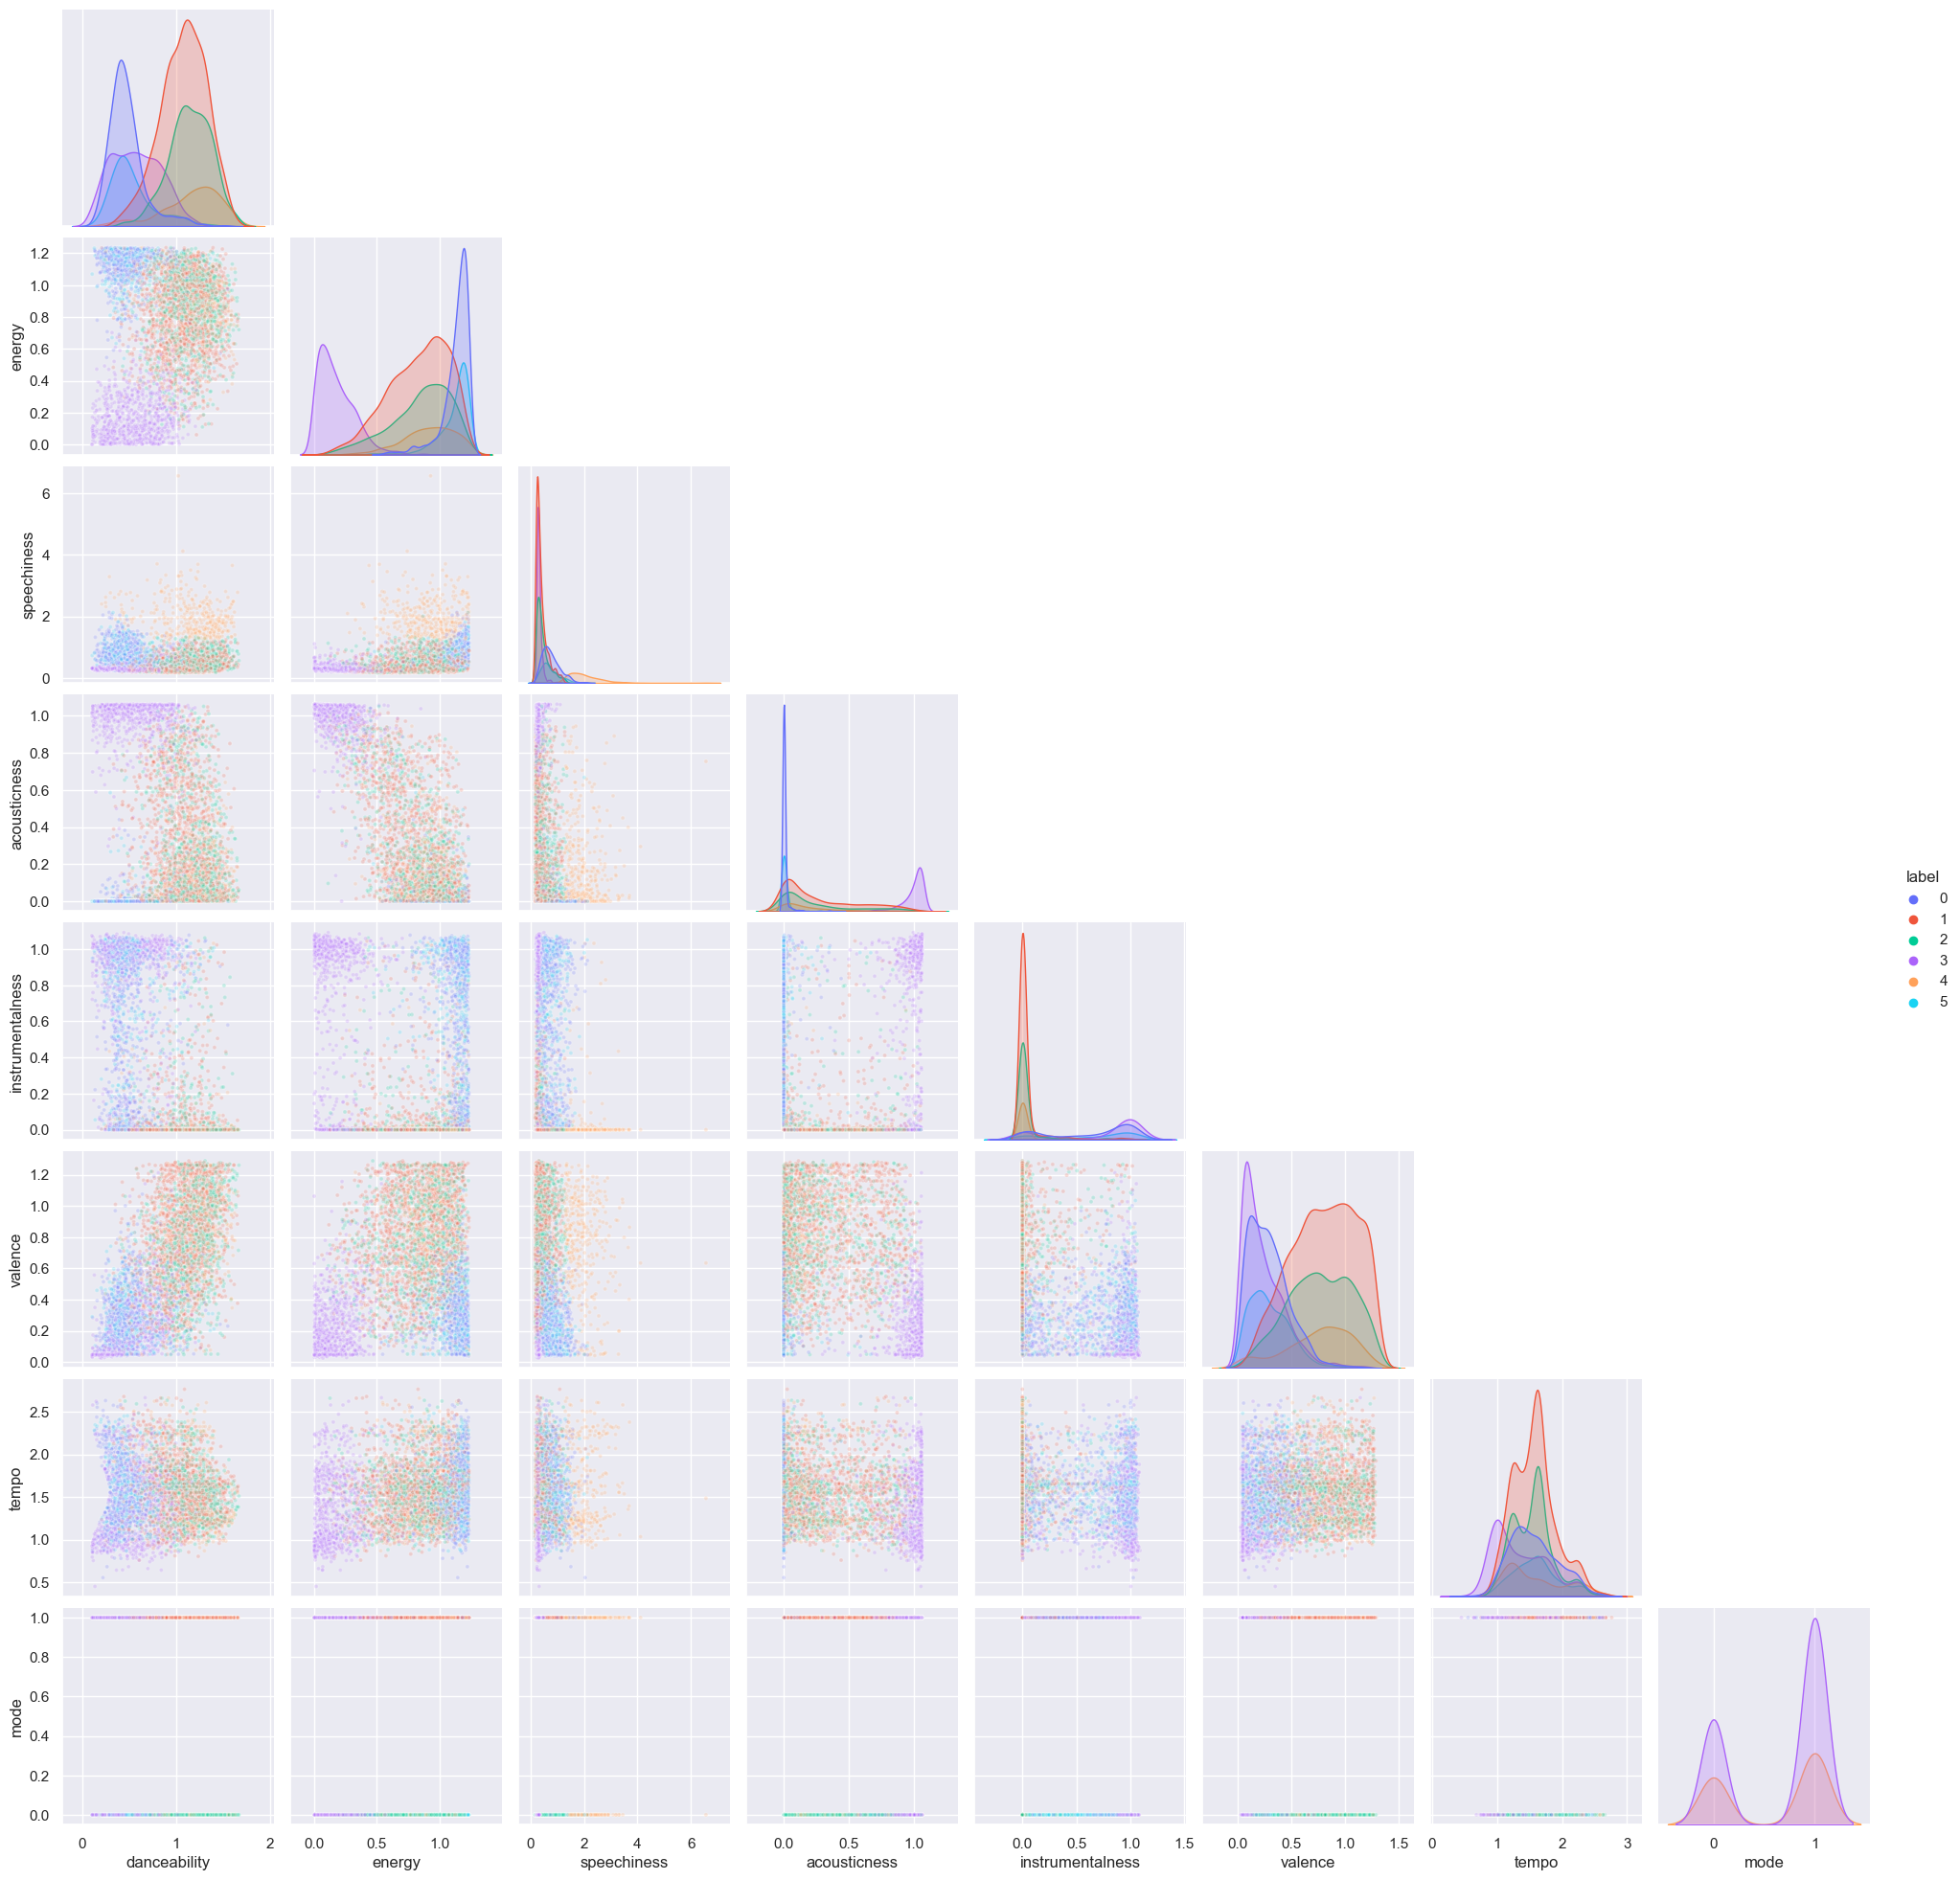

In [28]:
sns.pairplot(
    data = pca_df
    .join(labeled_df.label),
    palette=colormap[0:k],
    plot_kws=dict(marker=".", linewidth=1, alpha=0.2),
    hue='label',
    corner=True
);


### Characterizing the PCA transformation

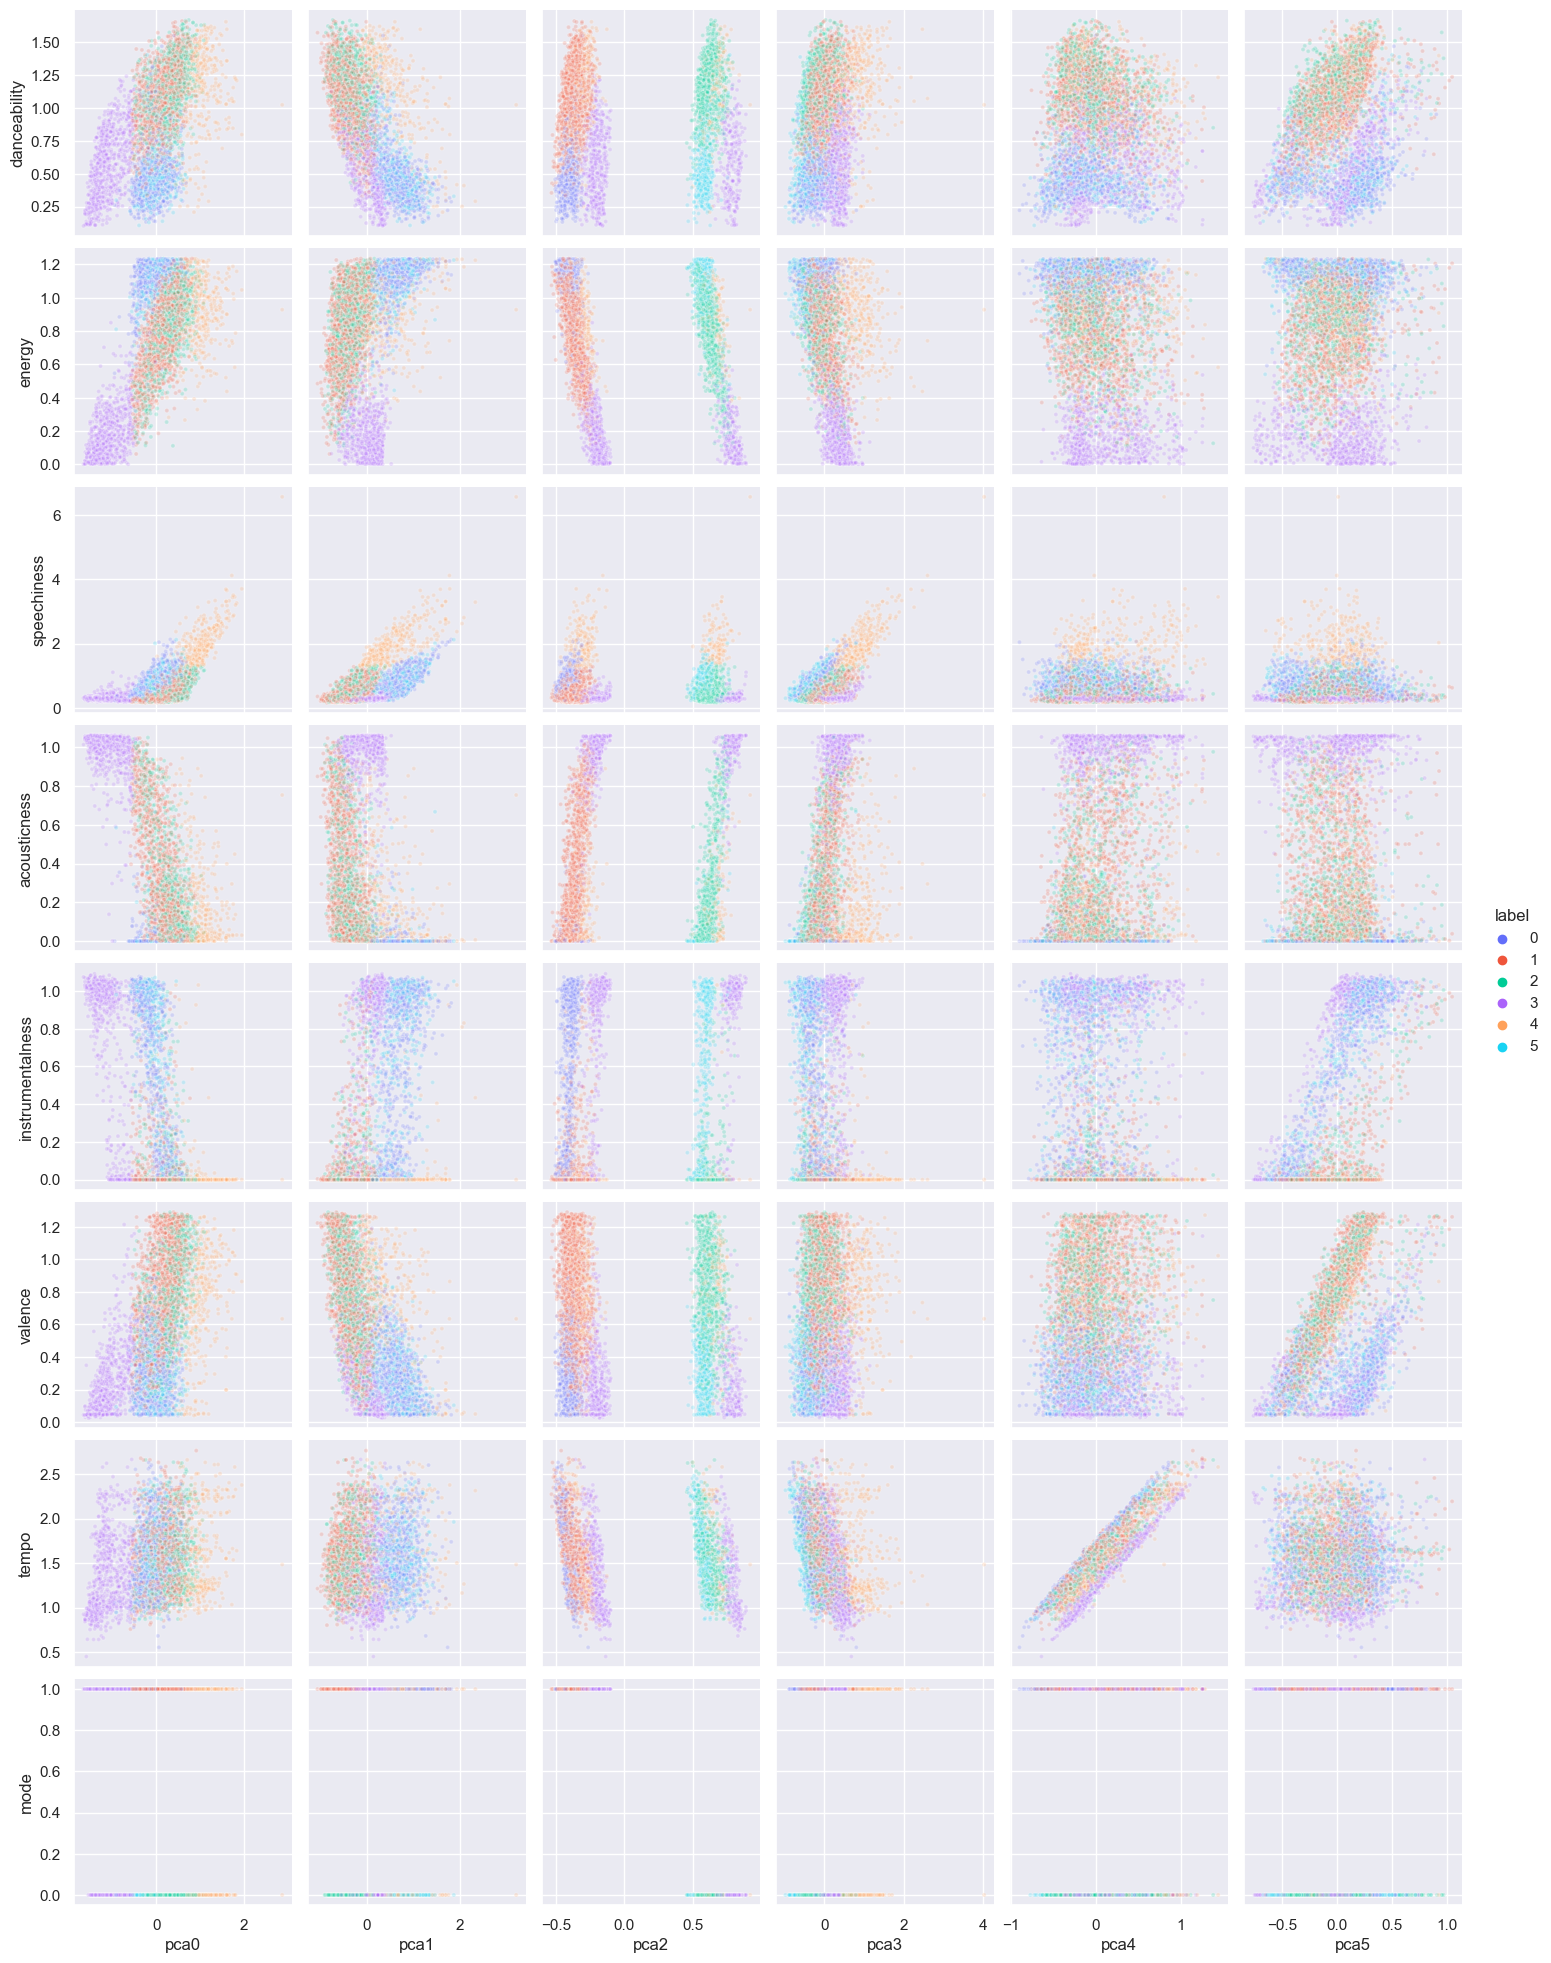

In [29]:
sns.pairplot(
    data = kmeans_df
      .join(pca_df)
      .join(labeled_df.label),
    plot_kws = dict(marker=".", linewidth=1, alpha=0.2),
    x_vars = kmeans_df.columns,
    y_vars = pca_df.columns,
    palette=colormap[0:k],
    hue = 'label'
);